# Weclome to Loan Credo an online platform for Commercial Banks to Verify Loan Applicants Credibilty



In [48]:
# Import The Necessary Libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import xgboost as xgb
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [49]:
# Load the dataset and view it to check if it is ok i.e sanity checks
df = pd.read_csv("Loan_Default_List.csv")

# You drop things that doesn't add any value to the target like the ids, year and region
# Also when you are building a model for a field you are not familiar with be sure to research the terminologies used as column head and their level of importance in the field even b4 dropping any column or running some correlation on the data
# You also drop things that doesn't necessary relates with the target after u must have done ur research e.g "term", "Neg_ammortization", "Credit_Worthiness", "construction_type"

df = df.drop(columns=["ID","year", "Region", "term", "Neg_ammortization", "Credit_Worthiness", "Security_Type","construction_type"], axis=1)

# Some Columns to drop dem might be optional i.e u might be unsure weda to do so but a pro tip to decide better is check if they’re mostly one category: if any column has 95%+ of rows in one category, drop it — it’s not adding signal. u can check by following the next 4 lines of code
for col in ["loan_limit", "approv_in_adv", "loan_type", "loan_purpose", "business_or_commercial", "interest_only", "lump_sum_payment", "occupancy_type", "credit_type", "co-applicant_credit_type", "age", "Gender","open_credit","total_units","submission_of_application","Secured_by"]:
    print(f"{col} value counts:")
    print(df[col].value_counts(normalize=True))
    print("-"*40)


ERROR! Session/line number was not unique in database. History logging moved to new session 571
loan_limit value counts:
loan_limit
cf     0.931341
ncf    0.068659
Name: proportion, dtype: float64
----------------------------------------
approv_in_adv value counts:
approv_in_adv
nopre    0.84339
pre      0.15661
Name: proportion, dtype: float64
----------------------------------------
loan_type value counts:
loan_type
type1    0.761236
type2    0.139652
type3    0.099112
Name: proportion, dtype: float64
----------------------------------------
loan_purpose value counts:
loan_purpose
p3    0.376569
p4    0.368927
p1    0.232462
p2    0.022042
Name: proportion, dtype: float64
----------------------------------------
business_or_commercial value counts:
business_or_commercial
nob/c    0.860348
b/c      0.139652
Name: proportion, dtype: float64
----------------------------------------
interest_only value counts:
interest_only
not_int     0.952176
int_only    0.047824
Name: proportion, dtyp

In [50]:
# Now that we are a bit sure Drop the ones not adding any sigal
df = df.drop(columns=["Secured_by", "open_credit","total_units", "lump_sum_payment"])
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)        # Don't wrap lines
df.head(5)

,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,business_or_commercial,loan_amount,rate_of_interest,Interest_rate_spread,Upfront_charges,interest_only,property_value,occupancy_type,income,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Status,dtir1
0,cf,Sex Not Available,nopre,type1,p1,nob/c,116500,NaN,NaN,NaN,not_int,118000.0,pr,1740.0,EXP,758,CIB,25-34,to_inst,98.728814,1,45.0
1,cf,Male,nopre,type2,p1,b/c,206500,NaN,NaN,NaN,not_int,NaN,pr,4980.0,EQUI,552,EXP,55-64,to_inst,NaN,1,NaN
2,cf,Male,pre,type1,p1,nob/c,406500,4.56,0.2000,595.0,not_int,508000.0,pr,9480.0,EXP,834,CIB,35-44,to_inst,80.019685,0,46.0
3,cf,Male,nopre,type1,p4,nob/c,456500,4.25,0.6810,NaN,not_int,658000.0,pr,11880.0,EXP,587,CIB,45-54,not_inst,69.376900,0,42.0
4,cf,Joint,pre,type1,p1,nob/c,696500,4.00,0.3042,0.0,not_int,758000.0,pr,10440.0,CRIF,602,EXP,25-34,not_inst,91.886544,0,39.0


In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 22 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   loan_limit                 145326 non-null  object 
 1   Gender                     148670 non-null  object 
 2   approv_in_adv              147762 non-null  object 
 3   loan_type                  148670 non-null  object 
 4   loan_purpose               148536 non-null  object 
 5   business_or_commercial     148670 non-null  object 
 6   loan_amount                148670 non-null  int64  
 7   rate_of_interest           112231 non-null  float64
 8   Interest_rate_spread       112031 non-null  float64
 9   Upfront_charges            109028 non-null  float64
 10  interest_only              148670 non-null  object 
 11  property_value             133572 non-null  float64
 12  occupancy_type             148670 non-null  object 
 13  income                     13

In [52]:
# Count how many null values appear in each column
df.isnull().sum()

loan_limit                    3344
Gender                           0
approv_in_adv                  908
loan_type                        0
loan_purpose                   134
business_or_commercial           0
loan_amount                      0
rate_of_interest             36439
Interest_rate_spread         36639
Upfront_charges              39642
interest_only                    0
property_value               15098
occupancy_type                   0
income                        9150
credit_type                      0
Credit_Score                     0
co-applicant_credit_type         0
age                            200
submission_of_application      200
LTV                          15098
Status                           0
dtir1                        24121
dtype: int64

In [53]:
# Sometimes missing Values doesn't occur randomly and could actually be informative
# So do well to check the missing values with respect to the target to ascertain if it is random or it correlates to the target by using the df.isnull().groupby(df['Target']).sum()
# Missingness is random if the fact that a value is missing has no relationship with the target (Status)
# It’s not random if, say, people skipping income fields are the ones with a (loan not approved or rejected loans)
# When it is confirmed that the missing values are not random then we can perform flagging
# Flagging means taking a column with so many missing values then inputting  0 or 1 only. Their job is to tell the model which rows were missing originally.
df.isnull().groupby(df['Status']).sum()


,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,business_or_commercial,loan_amount,rate_of_interest,Interest_rate_spread,Upfront_charges,interest_only,property_value,occupancy_type,income,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Status,dtir1
Status,,,,,,,,,,,,,,,,,,,,,,
0,2463,0,667,0,99,0,0,0,0,3156,0,2,0,7911,0,0,0,0,0,2,0,7811
1,881,0,241,0,35,0,0,36439,36639,36486,0,15096,0,1239,0,0,0,200,200,15096,0,16310


In [54]:
# from the check above we can see that some columns missing values combined range from tens, to hundreds and even the early thousands, but we are looking for something significantly large not few
# then you also notice that the remaining others range from the late thousands (income) to tens of thousands which is significantly large compared to others then these are the ones we will flag
# They include rate_of_interest, interest_rate_spread, property_value, income, LTV, dtir1
# Flagging
df["missing_rate_of_interest"] = df["rate_of_interest"].isna().astype(int)
df["missing_interest_rate_spread"] = df["Interest_rate_spread"].isna().astype(int)
df["missing_property_value"] = df["property_value"].isna().astype(int)
df["missing_income"] = df["income"].isna().astype(int)
df["missing_LTV"] = df["LTV"].isna().astype(int)
df["missing_dtir"] = df["dtir1"].isna().astype(int)


In [55]:
df_numerical = df.select_dtypes(include=["number"])
df_categorical = df.select_dtypes(include=["object"])


In [56]:
# Handle the missing values of the numerical columns except they begin with "missing" (like missing_income) by imputing some constant e.g median
for col in df_numerical.columns:
    if not col.startswith("missing_"):
        df[col].fillna(df[col].median(), inplace=True)


In [57]:
# Handle the missing values of the categorical columns by imputing some constant e.g missing or blank where there are no values
for col in df_categorical.columns:
    df[col].fillna("Missing", inplace=True)

In [58]:
# Encode the categorical columns
from sklearn.preprocessing import LabelEncoder

label_encoders = {}

for col in df_categorical.columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [59]:
# Find the Correlation values to know if to drop some more columns
corr_matrix = df.corr()
corr_with_target = corr_matrix["Status"].sort_values(ascending=False)
print(corr_with_target)

Status                          1.000000
missing_interest_rate_spread    1.000000
missing_rate_of_interest        0.996378
missing_property_value          0.587791
missing_LTV                     0.587791
missing_dtir                    0.438839
co-applicant_credit_type        0.144239
credit_type                     0.112760
submission_of_application       0.111729
dtir1                           0.082432
age                             0.056180
loan_type                       0.052301
Gender                          0.051794
LTV                             0.042656
loan_limit                      0.042084
Credit_Score                    0.004004
interest_only                  -0.013881
occupancy_type                 -0.018588
loan_purpose                   -0.027895
loan_amount                    -0.036825
approv_in_adv                  -0.037007
rate_of_interest               -0.046738
Interest_rate_spread           -0.049536
income                         -0.060618
missing_income  

In [60]:
# Drop either of rate_of_interest or interest_rate_spread
# Preferably drop interest_rate_spread bcos it is derived from rate_of_interest
df = df.drop(columns=["Interest_rate_spread"])

# Now notice that the correlation output having missing_interest_rate_spread    1.000000 and missing_rate_of_interest        0.996378 meaning these flagged columns are almost perfectly aligned with your target variable. This is bad bcos when you train your model with this data it won't learn genuine patterns it'll cheat or cram by using that flag alone to predict the target perfectly resulting to overfitting. So basically it’s a data leakage warning. This is one of the rare times where a feature that looks useful should be removed before modeling.
# Drop the columns that are too perfectly correlated (typically correlation > 0.95 with target):
df = df.drop(columns=["missing_interest_rate_spread", "missing_rate_of_interest"])

In [61]:
# Finding the correlation again after the drop to visualize with a heatmap
corr_matrix = df.corr()
corr_with_target = corr_matrix["Status"].sort_values(ascending=False)
print(corr_with_target)

Status                       1.000000
missing_property_value       0.587791
missing_LTV                  0.587791
missing_dtir                 0.438839
co-applicant_credit_type     0.144239
credit_type                  0.112760
submission_of_application    0.111729
dtir1                        0.082432
age                          0.056180
loan_type                    0.052301
Gender                       0.051794
LTV                          0.042656
loan_limit                   0.042084
Credit_Score                 0.004004
interest_only               -0.013881
occupancy_type              -0.018588
loan_purpose                -0.027895
loan_amount                 -0.036825
approv_in_adv               -0.037007
rate_of_interest            -0.046738
income                      -0.060618
missing_income              -0.065984
property_value              -0.080905
business_or_commercial      -0.092550
Upfront_charges             -0.095094
Name: Status, dtype: float64


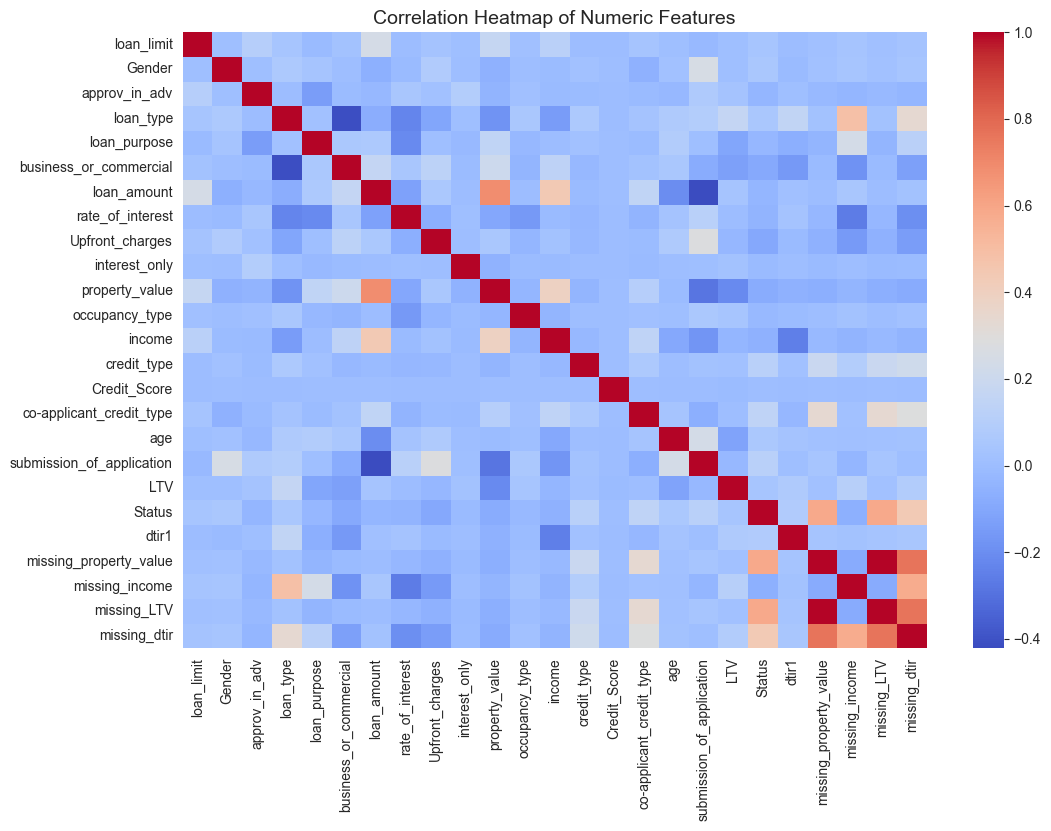

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
num_features_mx = df.corr()
sns.heatmap(num_features_mx, cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap of Numeric Features", fontsize=14)
plt.show()


In [63]:
# missing_ltv & missing_property has a good correlation with Status missing_ditr has a good correlation with Status but slightly weaker than the above missing_income has a good correlation with loan_type & missing_ditr missing_ltv strongly/highly correlates with missing_property_value and has a good correlation with missing_ditr missing_property has a good correlation with missing_ditr

In [64]:
# We will keep Missing_property_value and drop Missing_LTV despite dem strongly correlated.
# The reason is bcos when two features’ missing flags are strongly correlated, keep the one that represents the original input, not the derived metric and Missing_LTV comes from Missing_property_value from Research.
# We will keep missing_dtir, since it’s still moderately informative.
# drop missing_income it doesn’t directly relate to loan performance.

In [65]:
df = df.drop(columns=["missing_income", "missing_LTV"])

In [66]:
# Splitting the data into training and testing sets
X = df.drop(columns=["Status"])
y = df["Status"]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [67]:
# Next we train the model using the XGBClassifier but before we do this we need to discuss about the important parameters in the XGBClassifier because we are going to make use of them in the training of the model
# The n_estimators is basically the number of trees. If u set it to equal 200, The model will build 200 decision trees. More trees can improve accuracy but also increase training time and risk of overfitting.
# The learning_rate as the name implies is the rate at which the model learns, It Controls how much each tree corrects the errors of the previous ones. Smaller values, like 0.1, make learning slower but more accurate.
# The max_depth is basically the Tree depth. It Limits how deep each tree can grow. Deeper trees can learn more complex patterns but may overfit.
# The subsample is used for Row sampling. It takes a portion of the training data to build each tree. If it was set to equal 0.8, only 80% of the training data will be used to build each tree. This helps prevent overfitting and adds randomness.
# colsample_bytree is similar to the previous subsample but instead is used for Column sampling. If it was set at 0.8, only 80% of the features (columns) will be used when building each tree. This also helps reduce overfitting.
# random_state Ensures reproducibility. Using the same seed gives the same results every time you run the model. By now you should know what it is about
# eval_metric is basically the evaluation metric you want the model to use to evaluate how well it's doing during training, If you set it to equal logloss, it tells the model to use logarithmic loss to evaluate how well it's doing during training. This is common for binary classification problems.


In [68]:
# Save the medians from the training data
medians = X_train.median()
joblib.dump(medians, "medians.pkl")

['medians.pkl']

In [69]:
# Save the feature names (column order matters!)
feature_names = X_train.columns.tolist()
joblib.dump(feature_names, "feature_names.pkl")

['feature_names.pkl']

In [70]:
# Training the model
model = xgb.XGBClassifier(n_estimators=200, learning_rate=0.1, max_depth=5, subsample=0.8, colsample_bytree=0.8, random_state=42, eval_metric="logloss")
model.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [71]:
# Making Predictions
y_pred = model.predict(X_test)
print("Accuracy:",accuracy_score(y_test, y_pred))
print("\n Classification Report:\n", classification_report(y_test, y_pred))
print("\n Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.9973431088989037

 Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     22406
           1       0.99      1.00      0.99      7328

    accuracy                           1.00     29734
   macro avg       0.99      1.00      1.00     29734
weighted avg       1.00      1.00      1.00     29734


 Confusion Matrix:
 [[22327    79]
 [    0  7328]]


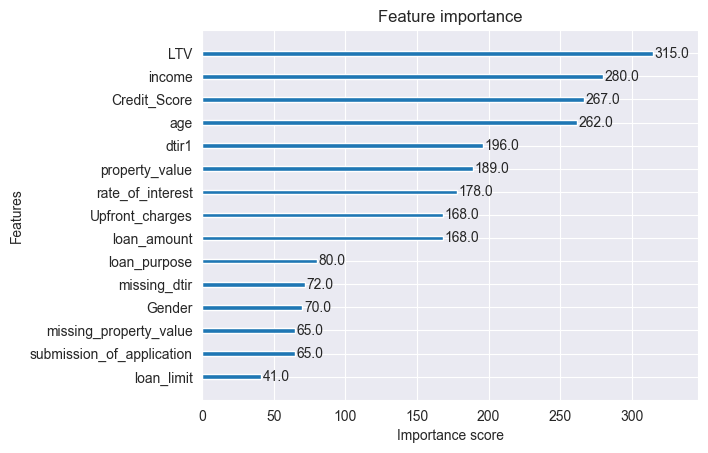

In [72]:
xgb.plot_importance(model, max_num_features=15)
plt.show()


In [73]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
print("Cross-validation accuracy:", scores)
print("Mean:", scores.mean(), "Std:", scores.std())


Cross-validation accuracy: [0.99677137 0.99784758 0.99710769 0.99761216 0.99720858]
Mean: 0.9973094773659783 Std: 0.00037990236756419744


In [74]:
# Save model and label encoder
joblib.dump(model, "model.pkl")
joblib.dump(label_encoders, "label_encoders.pkl")


['label_encoders.pkl']